# SNGNKO003

## 2. Telegrapher’s Equations

We are going to use Kirchhoff’s Laws for Voltage and and the node Law for Currents, to derive the set of equations that describes the transmission line. The Kirchhoff’s Voltage Law simply states that the sum of all potential differences over all elements in closed loop is zero i.e. $$\sum V_i = 0$$

The Node Law simply states that the sum of the currents flowing into or out of a node zero i.e.$$\sum I_i = 0$$

We look at the geometry we're given and we immediately notice that the first and last loop will have different configurations. We also note that we can treat the G resistor and C capacitor as normal resistors connected in parallel and calculate the effective Impendence i.e $$Z_{GC} = \left(\frac{1}{G} + i \omega C\right)^{-1}$$ 

So the first loop ends up looking like (after applying the Voltage Law): $$0 = U_0 - (R_i - i \omega L + R)I_0 - (Z_{GC})I_1 $$
and the last loop ends up looking like: $$0 = (Z_{GC})I_{n-1} - (R_l)I_{n}$$ where n is the number of the cells.
We are told that we have 500 cells, so when we apply the voltage law to everything in between we end up with: $$0 = (Z_{GC})I_{i-1} - (i \omega L + R)I_{i} - (Z_{GC})I_{i+1}$$ with $i = 2,3,...,n-1$

Now we can generate a system of linear equations we will later use a numpy package to solve, $\textit{numpy.linalg.solve()}$.

We Import all the modules and packages neccesary for our analysis and define all the constants and variables we will use to generate the system of linear equations of the form: $$Ax = b$$

where $A$ is a matrix representing the impendences for each element per loop, $x$ is a vector of associated currents which correspond to the impendences which when mutlipied results in $b$ which is a vector of associated Volatages in the wire per loop. 

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft


cell_n = 500           # cells
l = 5                  # m
dx = l/cell_n          # segmenting the circuit 

C = 100e-12 * dx       # F
Ri =  50 + 0j          # Ohm
G = 1e9 * dx           # Ohm
R = 30e-6 * dx         # Ohm
L = 270e-9 * dx        # H
Rl = 52                # Ohm
U0 = 100               # V
tau = 5e-9             # Decay time

f = 100e6
omega = 2*(np.pi)*f

###########################################################################
###         Voltages of the different components of the circuit         ###
###########################################################################
LI = L*omega*(1j)
CI = 1/(omega*C*(1j))

# Impendence for the components connected in series #
LR = LI + R

# Impendence for the components connected in parallel #
GC = 1/((1/G) + 1/(CI))

# Types of curcuits #
circuit = ['Open','Short','100 Ohm']
short_R = 0
open_R = 10**40


## An empty list to append the voltages and currents for each curcuit configuration
Cable_I = []
CC = []
CNV = []
Cable_V = []

###########################################################################
### Matrix Generation to be generated to encode the system of equations ###
###########################################################################

for a in circuit:
    V = np.zeros(cell_n, dtype = complex) # the b in our equation Rx = V
    V[0] = U0
    Res = []
    for i in range(cell_n):         ##  creating an array with the currents(unknown) we looking at in the range, from 0 to 499
        if i == 0:                  ##  First cell working with current I_0
            row = np.zeros(cell_n, dtype = complex)
            LRcur = Ri + LR + GC
            GCcur = -GC
            row[i] = LRcur          ##  first entry going around loop in first cell with currents I_0
            row[i + 1] = GCcur      ##  Next with currents I_1

        elif i == cell_n - 1:
            row = np.zeros(cell_n, dtype = complex)
            if a == 'Open':         ##  End of circuit with open circuit imples Rl = really big
                LRcur = GC + open_R
                GCcur = -GC 
                row[i] = LRcur
                row[i - 1] = GCcur

            elif a == 'Short':      ##  End of circuit with short circuit imples Rl = 0
                LRcur = GC + short_R
                GCcur = -GC
                row[i] = LRcur
                row[i - 1] = GCcur
            
            elif a == '100 Ohm':    ##  End of circuit with terminal resistor with resistance Rl = 100
                LRcur = GC + Rl
                GCcur = -GC
                row[i] = LRcur
                row[i - 1] = GCcur

        else:
            row = np.zeros(cell_n, dtype = complex)
            LRcur = LR + 2*GC
            GCcur = -GC
            row[i] = LRcur
            row[i - 1] = GCcur
            row[i + 1] = GCcur
        Res.append(row)

    current = np.linalg.solve(Res,V)            ## Solving the system of linear equations thus obtaining current values
    Nv = []
    Av = [U0]
    i = 0
    for i in range(cell_n):
            if i == 0:
                V1 = U0 - current[i]*(Ri + LR)  ## Calculating the voltage by multiplying the currents with the impedences
                Nv.append(V1)
                Av.append(V1)
            elif i == (cell_n - 1):
                pass
            else:
                V1 = Nv[i-1] - current[i]*LR
                Nv.append(V1)
                Av.append(V1)
    
    Cable_I.append(current)         ## Current along the transmission line
    Cable_V.append(Av)              ## Voltage along the transmission line

In the code above, you will notice that we have three different configurations for the last loop depending on whether we're dealing with an Open, Short, or Terminal Load Circuit. We specify what each case imposes on the termination resistor $R_l$. 

For Open: $R_l \approx \text{really big}$

For Short: $R_l = 0 \Omega$ 

Lastly for the Terminal Load: $R_l = 100 \Omega$

Now that we have calculated both the currents and voltages across the wire, we can easily determine the middle and end voltage by looking at the indexes that is in the middle and at the end for the voltage for each circuit configuration. The Volages were recorded on the table below.

In [89]:
### Calculating the Voltage between two points to determine the Voltage between wires in the
# middle and at the end of the cable ###                
i=0
mid_V = []
end_V = []
for i in range(len(Cable_V)):    ## Cable_V is the cable voltage for all 3 circuit configurations and 
    mV = Cable_V[i][250]         ## since we have 500 cells, the middle will have index 250 
    eV = Cable_V[i][499]         ## and the end will have index 499
    mid_V.append(np.abs(mV))
    end_V.append(np.abs(eV))

a = ['Open Circuit', 'Short Circuit', '100 Ohms']   ## Tabulating the results using dictionary and a dataFrame
data = {
    'Circuit Configuration': a,
    'middle voltage(V)': mid_V,
    'end voltage(V)': end_V}
   
df = pd.DataFrame(data)
print(df)

  Circuit Configuration  middle voltage(V)  end voltage(V)
0          Open Circuit          29.320611    1.017886e+02
1         Short Circuit          97.964361    2.639699e-12
2              100 Ohms          51.149115    5.091993e+01


To comment on the wave forms of the voltages in these three conditions, it is useful for us to plot them first.

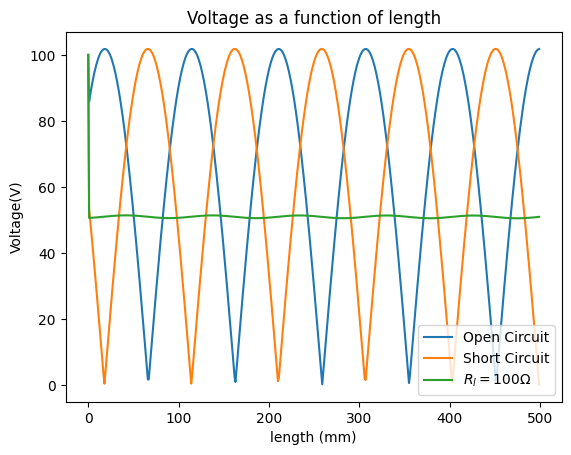

In [90]:
plt.plot([i for i in range(cell_n)], np.absolute(Cable_V[0]), label="Open Circuit")
plt.plot([i for i in range(cell_n)], np.absolute(Cable_V[1]), label="Short Circuit")
plt.plot([i for i in range(cell_n)], np.absolute(Cable_V[2]), label="$R_l = 100\Omega$")
plt.xlabel("length (mm)")
plt.ylabel("Voltage(V)")
plt.legend(loc = 'best')
plt.title("Voltage as a function of length")
plt.show()

We first note that the voltage is oscillating for all three cases with the extrema looking identical and are only out of phase with each other. We also notice that all three are oscillating around $50\Omega$, which might mean there is something interesting happening around there. I used an input voltage $U_0 = 100V$, just to scale the amplitude up and a result, we see that the voltage never surpasses its amplitude $100V$.

To find the value of the termination resistor RL for which the difference between the minimum and maximum amplitude of the voltage along the transmission line is smallest, I manually varried the value of $R_l$ to find the which $R_l$ results with the smallest amplitude. It turns out that the $R_l$ that minimizes the difference is very close to the value at which these oscillations oscillate about i.e. $$R_l = 52 \Omega$$

Something interesting is indeed happening around that region.

For the lasts parts of this tutorial, we are going to be working with an exponential voltage which is a function of time given by: $$V(t) = V_0e^{-(t-t_0)/\tau}\Theta(t-t_0)$$ where $t_0$ is the start time of the signal and the decay time $\tau = 5 \times 10^{-9}s$.

PLEASE NOTE THAT PLOT ABOVE IS GENERATED USING $R_l = 52 \Omega$. Simply change the termination Resistance to $R_l = 100 \Omega$ to generate the plots for the first parts of the Tutorial.

We now compute the Fourier Transform of the voltage as a function of time using the numpy package $\textit{numpy.fft}$.

We plot the result of the amplitude of the voltage as a function of frequency.

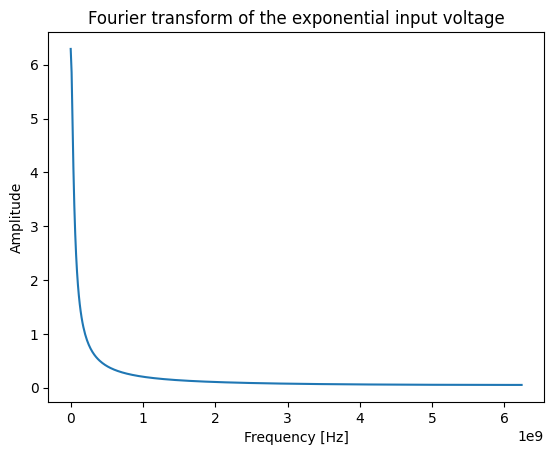

In [91]:
V = 0
##Fourier Transform of input signal

t = np.linspace(0,80e-9,1000)       ## defining time for the input signal
V = U0*np.exp(-t/tau)               ## The equation describing the voltage as a function of time

ffts = fft(V)                       

Time = t[1] - t[0]                     ## sampling interval 
n = len(t)                             ## number of samples

f = np.linspace(0, 1 / Time, n)        ## frequency calculated from the interval determined earlier
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.title('Fourier transform of the exponential input voltage')
plt.plot(f[:n//2], np.abs(ffts)[:n//2]*1/n)  # 1/n is a normalization factor
plt.show()

To determine the measured voltage across the termination resistor, we single used the commonly known equation: $$V_0 = I_{n}R_l$$

where we simply determine our initial amplitude $U_0$ and substitute it into: $$V(t) = V_0e^{-(t-t_0)/\tau}\Theta(t-t_0)$$

In [92]:
VRL = (np.abs(Cable_V[2][499])*Rl)*np.exp(-t[999]/tau)
print("The measured voltage across the termination resistor is: ", np.real(VRL), "V")

The measured voltage across the termination resistor is:  0.00029797470839065777 V


The plot of the voltage as a function of time looks like:

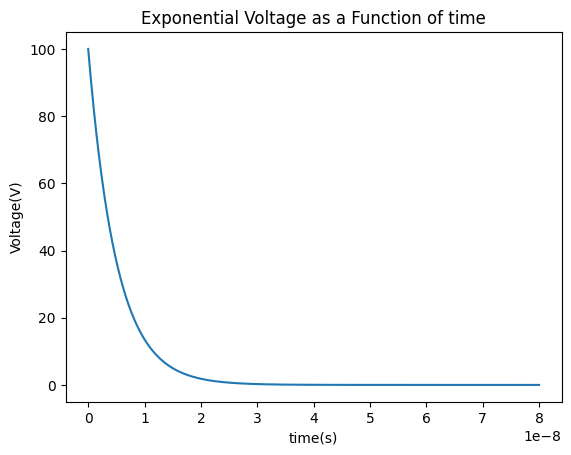

In [93]:
## Plotting the Exponential Voltage as a function of time ##
plt.plot(t,V)
plt.ylabel("Voltage(V)")
plt.xlabel("time(s)")
plt.title('Exponential Voltage as a Function of time')
plt.show()

This is indeed expected behaviour for the voltage because it is defined as an exponential decay and the presence of $R_l$ does not really affect how fast it decays.


The speed of the signal can be calculated from the angular frequency $\omega$. We know that for an LCR circuit, $\omega$ is given by: $$\omega = \frac{1}{\sqrt{LC}}$$

The speed of the signal is then given by: $$\nu = 2\pi \lambda \sqrt{LC}$$

In [95]:
w = 1/np.sqrt(L*C)
Lambda = 0.01 #m 
wave_speed = Lambda*w/(2*np.pi)
print('The signal speed is: ', wave_speed, "meters per second")

The signal speed is:  30629383.07898845 meters per second
